# Librerías

In [2]:
import numpy as np
import pandas as pd
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.spatial.distance import pdist
from scipy.integrate import solve_ivp, odeint

# Parte 1.- Variación paramétrica

In [3]:
#Cantidades variables
angulos = [10, 15, 20, 25]
longitudes = [23.9, 36.3, 52.2]
masas = [7.0, 31.0, 50.0]
masas_ = [0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.031, 0.007, 0.031, 0.050]

#Periodos de oscilación medidos
T_angular = [1.21, 1.24, 1.25, 1.25]
T_longitudinal = [1.06, 1.21, 1.47]
T_masico = [1.21, 1.22, 1.25]
T = T_angular + T_longitudinal + T_masico

#Desviaciones Estándar
DE_angular = [0.00826, 0.00731, 0.00371, 0.00388]
DE_longitudinal = [0.00852, 0.00826, 0.00367]
DE_masico = [0.00204, 0.00975, 0.00637]

### Variación angular

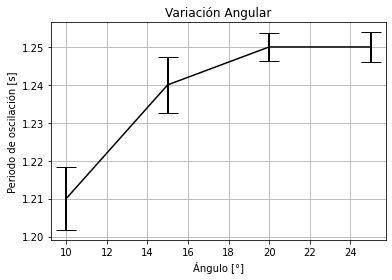

In [4]:
#crear gráfico de líneas con barras de error
fig1, ax1 = plt.subplots ()

ax1.errorbar(angulos, T_angular, yerr=DE_angular, capsize=10, elinewidth=2, color='black')

ax1.grid(True)
ax1.set_title('Variación Angular')
ax1.set_xlabel('Ángulo [°]')
ax1.set_ylabel('Periodo de oscilación [s]')

plt.show()

### Variación longitudinal

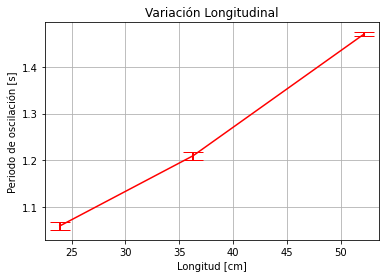

In [5]:
fig2, ax2 = plt.subplots ()

ax2.errorbar(longitudes, T_longitudinal, yerr=DE_longitudinal, capsize=10, elinewidth=2, color='red')

ax2.grid(True)
ax2.set_title('Variación Longitudinal')
ax2.set_xlabel('Longitud [cm]')
ax2.set_ylabel('Periodo de oscilación [s]')

plt.show()

### Variación másica

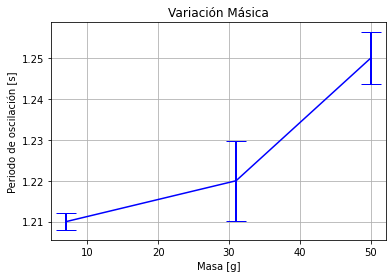

In [6]:
fig3, ax3 = plt.subplots ()

ax3.errorbar(masas, T_masico, yerr=DE_masico, capsize=10, elinewidth=2, color='blue')

ax3.grid(True)
ax3.set_title('Variación Másica')
ax3.set_xlabel('Masa [g]')
ax3.set_ylabel('Periodo de oscilación [s]')

plt.show()

# Lectura de datos

In [8]:
files = ['10grados.csv', '15grados.csv', '20grados.csv', '25grados.csv', 
         '26cm.csv', '10grados.csv', '52cm.csv', 'chica.csv', 'mediano.csv', 'grande.csv']
initial_angles = [10.0, 15.0, 20.0, 25.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0]

### Funciones

In [11]:
def f_nolineal(time, r, A):
    omega = r[0]
    theta = r[1]
    return np.array([-A * np.sin(theta), omega])

def f_no_lineal_amort(time, r, A, B):
    omega = r[0]
    theta = r[1]
    return np.array([omega, - B*omega - A* np.sin(theta)])

def f_lineal(initial_angle, time, w):
    lineal = [initial_angle * np.cos(w*t) for t in time]
    return lineal

def f_lineal_amort(time, r, A, B):
    omega = r[0]
    theta = r[1]
    return np.array([- B*omega - A*theta, omega])


def read_data(index, n_rows, l):
    global files, initial_angles
    #Leemos los datos
    file_name = 'data/'+ files[index]
    data = pd.read_csv(file_name, nrows=n_rows)

    #Limpiamos los datos haciendo un moving-avarage
    t = data[['t']]
    x = data[['x']].rolling(3, min_periods=1).mean()
    theta = []
    
    for x_ in x.values:
        aux = x_/100
        theta.append(np.arcsin(aux/l))
    
    initial_conditions = [0, np.radians(initial_angles[index])]
    
    return data, theta, t.values, initial_conditions
    

def factor_c(index, l, ciclos=10):
    global files, initial_angles, T, masas_

    #Leemos los datos
    file_name = 'data/'+ files[index]
    data = pd.read_csv(file_name)

    #Limpiamos los datos haciendo un moving-avarage
    t = data[['t']]
    x = data[['x']].rolling(3, min_periods=1).mean()
    theta = []

    for x_ in x.values:
        aux = x_/100
        theta.append(np.arcsin(aux/l))

    peaks = find_peaks(np.squeeze(theta))
    
    a1 = [] #Tiempo
    a2 = [] #Ángulo

    for p in range(len(peaks[0])):
        aux = peaks[0][p]
        a1.append(t.values[aux])
        a2.append(theta[aux])
    
    #Encuentra picos positivos y negativos, así que hay que multiplicar por 2 para encontra los picos positivos
    try:
        delta = (1 / ciclos)*np.log(a2[0]/a2[2*ciclos]) 
    except:
        delta = (1 / ciclos)*np.log(a2[0]/a2[ciclos]) 
        
    zeta = delta/np.sqrt((2*np.pi)**2+delta)
    wn = (2*np.pi)/(T[index]*np.sqrt(1-zeta**2))
    wd = wn*np.sqrt(1-zeta**2)
    crit = 2*masas_[index]*wn
    c = zeta*crit

    return a1, a2, delta, zeta, wn, wd, crit, c



## Caso 1: Variación angular

### Angulo inicial 10°

In [12]:
ciclos = 10
case = 0
l = 0.363
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.00772494]
Zeta: [0.00122934]
Omega_n: [5.19271905]
Omega_d: [5.19271513]
c crítico: [0.32194858]
c: [0.00039579]


In [15]:
#Valores nominales
g = 9.81
l = 0.363
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x1_df, t1_df, initial_conditions = read_data(case, limit, l)
n = len(t1_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [16]:
c1_no_lineal = solve_ivp(f_nolineal, (0, t1_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c1_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t1_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c1_lineal = f_lineal(initial_conditions[1], t1_df, np.sqrt(A))
c1_lineal_amort = solve_ivp(f_lineal_amort, (0, t1_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

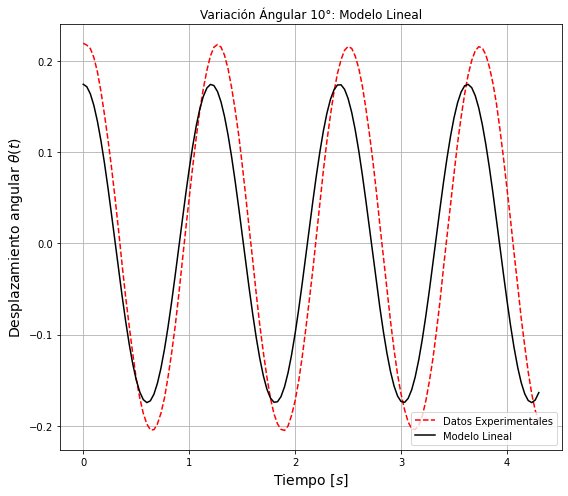

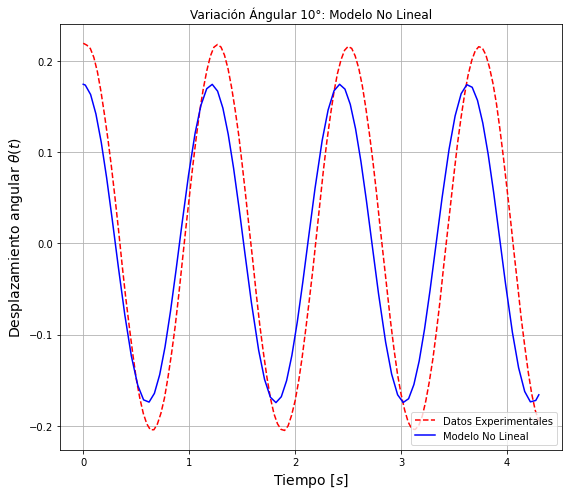

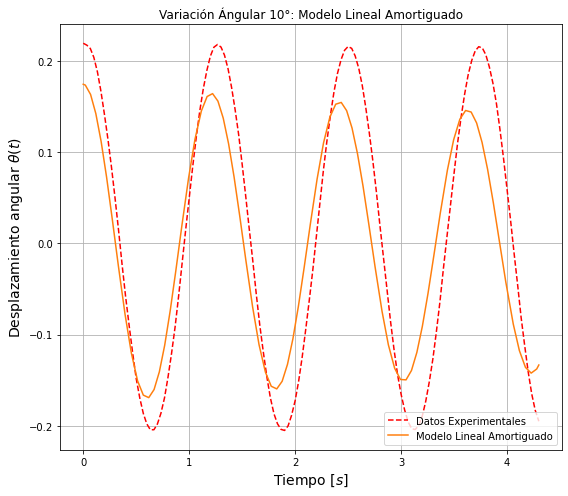

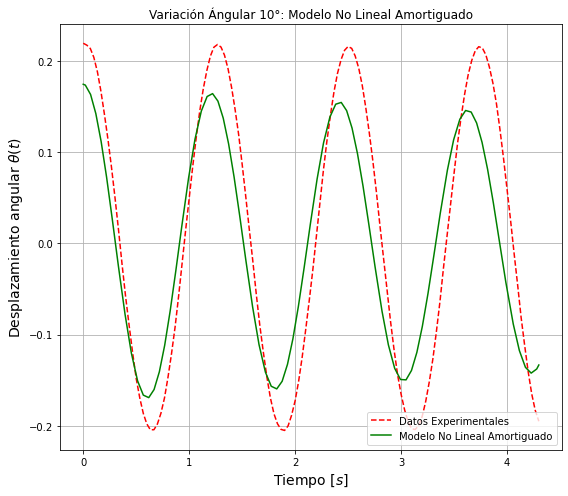

In [17]:
#Grafica 1
fig_c1_1, ax_c1_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c1_1.plot(t1_df, x1_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c1_1.plot(t1_df, c1_lineal, 'k') # Modelo Lineal
ax_c1_1.grid(True)
ax_c1_1.set_title("Variación Ángular 10°: Modelo Lineal")
ax_c1_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c1_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c1_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c1_2, ax_c1_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c1_2.plot(t1_df, x1_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c1_2.plot(c1_no_lineal.t, c1_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c1_2.grid(True)
ax_c1_2.set_title("Variación Ángular 10°: Modelo No Lineal")
ax_c1_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c1_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c1_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c1_3, ax_c1_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c1_3.plot(t1_df, x1_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c1_3.plot(c1_lineal_amort.t, c1_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c1_3.grid(True)
ax_c1_3.set_title("Variación Ángular 10°: Modelo Lineal Amortiguado")
ax_c1_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c1_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c1_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c1_4, ax_c1_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c1_4.plot(t1_df, x1_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c1_4.plot(c1_no_lineal_amort.t, c1_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c1_4.grid(True)
ax_c1_4.set_title("Variación Ángular 10°: Modelo No Lineal Amortiguado")
ax_c1_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c1_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c1_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()




In [69]:
X_c1_1 = np.vstack([c1_lineal, x1_df])
X_c1_2 = np.vstack([np.expand_dims(c1_no_lineal.y[1], axis=1), x1_df])
X_c1_3 = np.vstack([np.expand_dims(c1_lineal_amort.y[1], axis=1), x1_df])
X_c1_4 = np.vstack([np.expand_dims(c1_no_lineal_amort.y[1], axis=1), x1_df])
d1 = pdist(X_c1_1, 'euclidean')
d2 = pdist(X_c1_2, 'euclidean')
d3 = pdist(X_c1_3, 'euclidean')
d4 = pdist(X_c1_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')


Distancia Euclidiana Modelo Lineal: 5348.754803550323
Distancia Euclidiana Modelo No Lineal: 3614.23313703612
Distancia Euclidiana Modelo Lineal Amortiguado: 3489.5564407701618
Distancia Euclidiana Modelo No Lineal Amortiguado: 3489.5564407701618


### Angulo inicial 15°


In [18]:
ciclos = 10
case = 1
l = 0.363
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.00378405]
Zeta: [0.00060222]
Omega_n: [5.06708584]
Omega_d: [5.06708493]
c crítico: [0.31415932]
c: [0.00018919]


In [21]:
#Valores nominales
g = 9.81
l = 0.363
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x2_df, t2_df, initial_conditions = read_data(case, limit, l)
n = len(t2_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [22]:
c2_no_lineal = solve_ivp(f_nolineal, (0, t2_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c2_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t2_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c2_lineal = f_lineal(initial_conditions[1], t2_df, np.sqrt(A))
c2_lineal_amort = solve_ivp(f_lineal_amort, (0, t2_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

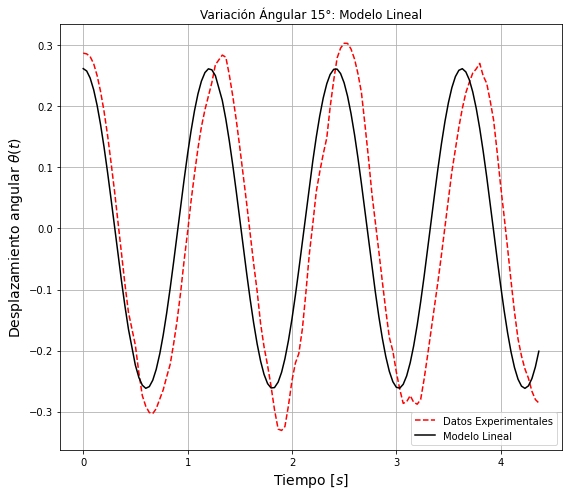

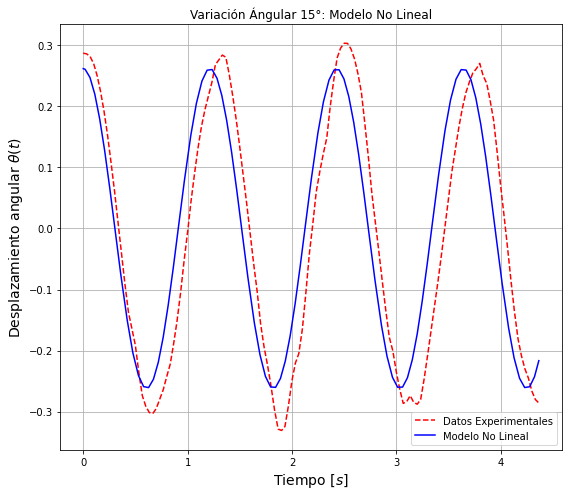

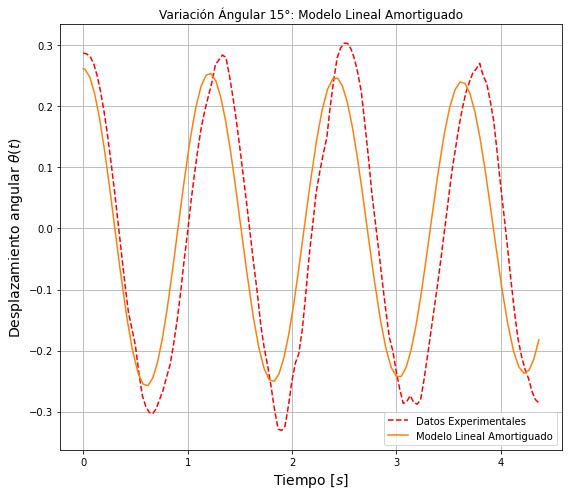

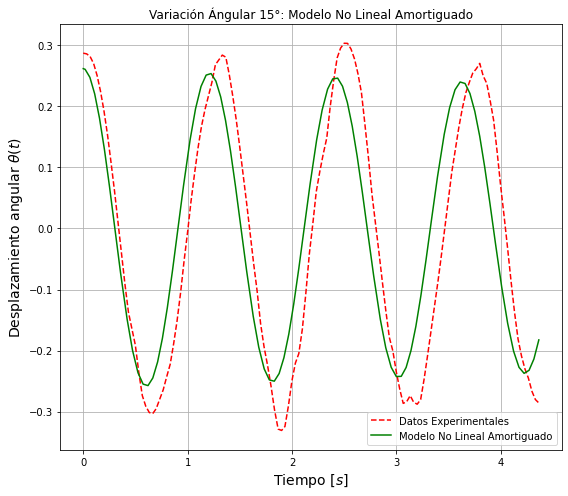

In [23]:
#Grafica 1
fig_c2_1, ax_c2_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c2_1.plot(t2_df, x2_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c2_1.plot(t2_df, c2_lineal, 'k') # Modelo Lineal
ax_c2_1.grid(True)
ax_c2_1.set_title("Variación Ángular 15°: Modelo Lineal")
ax_c2_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c2_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c2_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c2_2, ax_c2_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c2_2.plot(t2_df, x2_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c2_2.plot(c2_no_lineal.t, c2_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c2_2.grid(True)
ax_c2_2.set_title("Variación Ángular 15°: Modelo No Lineal")
ax_c2_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c2_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c2_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c2_3, ax_c2_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c2_3.plot(t2_df, x2_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c2_3.plot(c2_lineal_amort.t, c2_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c2_3.grid(True)
ax_c2_3.set_title("Variación Ángular 15°: Modelo Lineal Amortiguado")
ax_c2_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c2_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c2_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c2_4, ax_c2_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c2_4.plot(t2_df, x2_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c2_4.plot(c2_no_lineal_amort.t, c2_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c2_4.grid(True)
ax_c2_4.set_title("Variación Ángular 15°: Modelo No Lineal Amortiguado")
ax_c2_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c2_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c2_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()



In [70]:
X_c2_1 = np.vstack([c2_lineal, x2_df])
X_c2_2 = np.vstack([np.expand_dims(c2_no_lineal.y[1], axis=1), x2_df])
X_c2_3 = np.vstack([np.expand_dims(c2_lineal_amort.y[1], axis=1), x2_df])
X_c2_4 = np.vstack([np.expand_dims(c2_no_lineal_amort.y[1], axis=1), x2_df])
d1 = pdist(X_c2_1, 'euclidean')
d2 = pdist(X_c2_2, 'euclidean')
d3 = pdist(X_c2_3, 'euclidean')
d4 = pdist(X_c2_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 7658.383997181967
Distancia Euclidiana Modelo No Lineal: 5478.70637712745
Distancia Euclidiana Modelo Lineal Amortiguado: 5438.302555372088
Distancia Euclidiana Modelo No Lineal Amortiguado: 5438.302555372088


### Angulo inicial 20°

In [24]:
ciclos = 10
case = 2
l = 0.363
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.03077129]
Zeta: [0.0048955]
Omega_n: [5.02660848]
Omega_d: [5.02654825]
c crítico: [0.31164973]
c: [0.00152568]


In [25]:
#Valores nominales
g = 9.81
l = 0.363
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x3_df, t3_df, initial_conditions = read_data(case, limit, l)
n = len(t3_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [26]:
c3_no_lineal = solve_ivp(f_nolineal, (0, t3_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c3_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t3_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c3_lineal = f_lineal(initial_conditions[1], t3_df, np.sqrt(A))
c3_lineal_amort = solve_ivp(f_lineal_amort, (0, t3_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

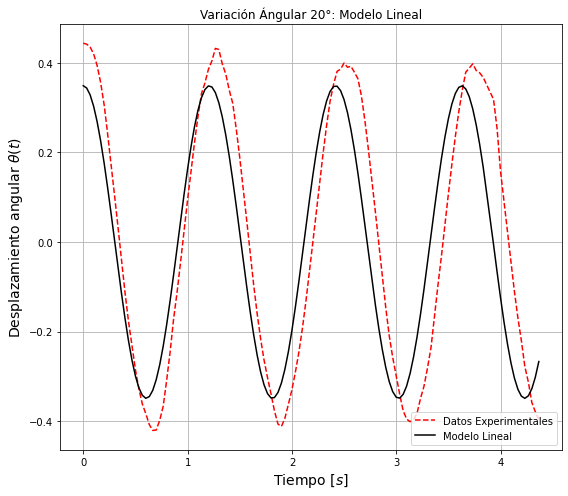

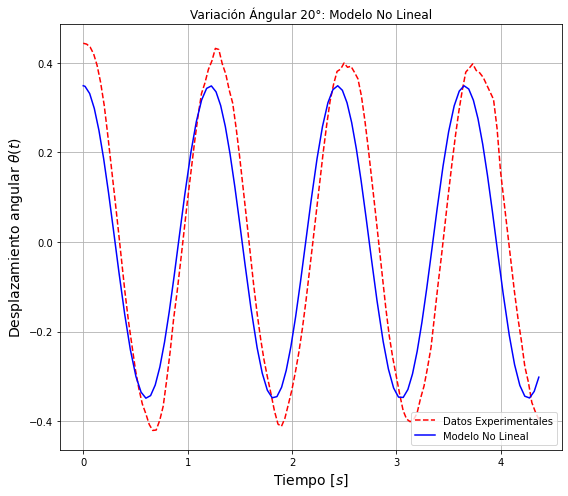

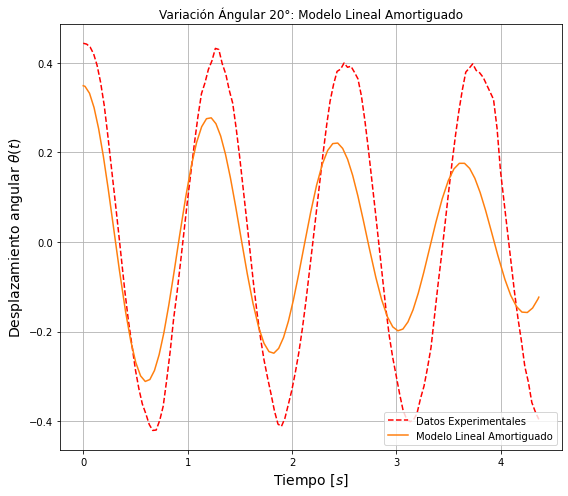

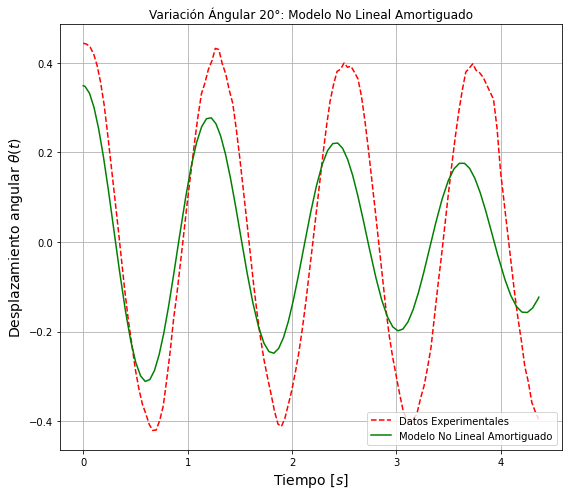

In [27]:
#Grafica 1
fig_c3_1, ax_c3_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c3_1.plot(t3_df, x3_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c3_1.plot(t3_df, c3_lineal, 'k') # Modelo Lineal
ax_c3_1.grid(True)
ax_c3_1.set_title("Variación Ángular 20°: Modelo Lineal")
ax_c3_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c3_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c3_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c3_2, ax_c3_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c3_2.plot(t3_df, x3_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c3_2.plot(c3_no_lineal.t, c3_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c3_2.grid(True)
ax_c3_2.set_title("Variación Ángular 20°: Modelo No Lineal")
ax_c3_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c3_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c3_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c3_3, ax_c3_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c3_3.plot(t3_df, x3_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c3_3.plot(c3_lineal_amort.t, c3_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c3_3.grid(True)
ax_c3_3.set_title("Variación Ángular 20°: Modelo Lineal Amortiguado")
ax_c3_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c3_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c3_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c3_4, ax_c3_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c3_4.plot(t3_df, x3_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c3_4.plot(c3_no_lineal_amort.t, c3_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c3_4.grid(True)
ax_c3_4.set_title("Variación Ángular 20°: Modelo No Lineal Amortiguado")
ax_c3_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c3_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c3_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()


In [71]:
X_c3_1 = np.vstack([c3_lineal, x3_df])
X_c3_2 = np.vstack([np.expand_dims(c3_no_lineal.y[1], axis=1), x3_df])
X_c3_3 = np.vstack([np.expand_dims(c3_lineal_amort.y[1], axis=1), x3_df])
X_c3_4 = np.vstack([np.expand_dims(c3_no_lineal_amort.y[1], axis=1), x3_df])
d1 = pdist(X_c3_1, 'euclidean')
d2 = pdist(X_c3_2, 'euclidean')
d3 = pdist(X_c3_3, 'euclidean')
d4 = pdist(X_c3_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 10595.266186591252
Distancia Euclidiana Modelo No Lineal: 7854.318203971564
Distancia Euclidiana Modelo Lineal Amortiguado: 6975.8124510626385
Distancia Euclidiana Modelo No Lineal Amortiguado: 6975.8124510626385


### Angulo inicial 25°

In [28]:
ciclos = 10
case = 3
l = 0.363
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.01952321]
Zeta: [0.00310645]
Omega_n: [5.0265725]
Omega_d: [5.02654825]
c crítico: [0.31164749]
c: [0.00096812]


In [29]:
#Valores nominales
g = 9.81
l = 0.363
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x4_df, t4_df, initial_conditions = read_data(case, limit, l)
n = len(t4_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [30]:
c4_no_lineal = solve_ivp(f_nolineal, (0, t4_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c4_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t4_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c4_lineal = f_lineal(initial_conditions[1], t4_df, np.sqrt(A))
c4_lineal_amort = solve_ivp(f_lineal_amort, (0, t4_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

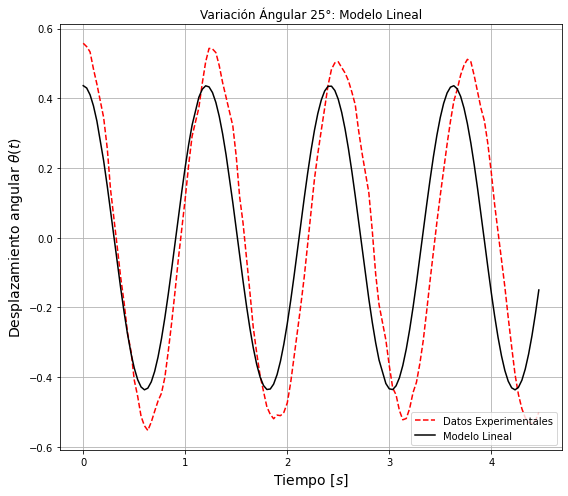

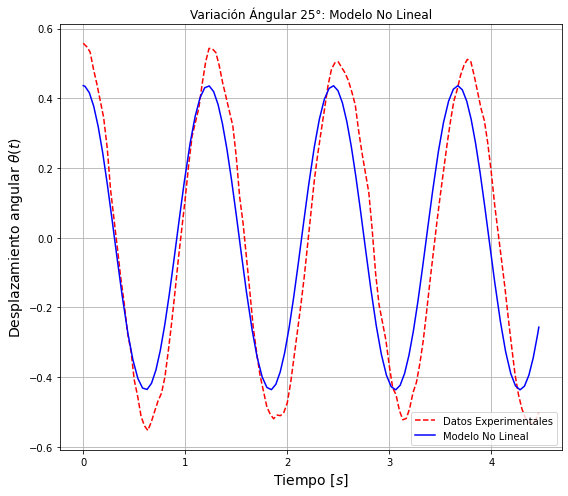

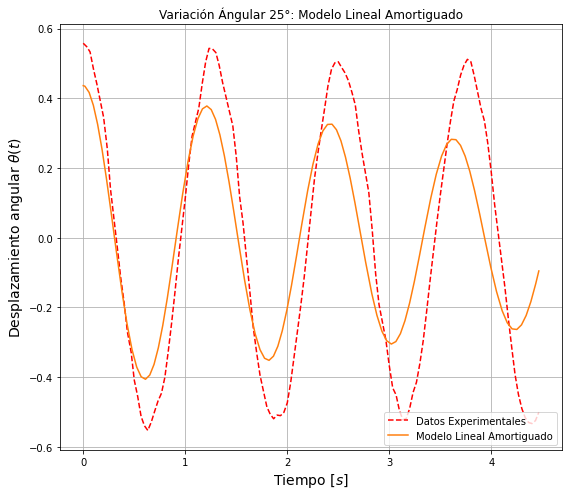

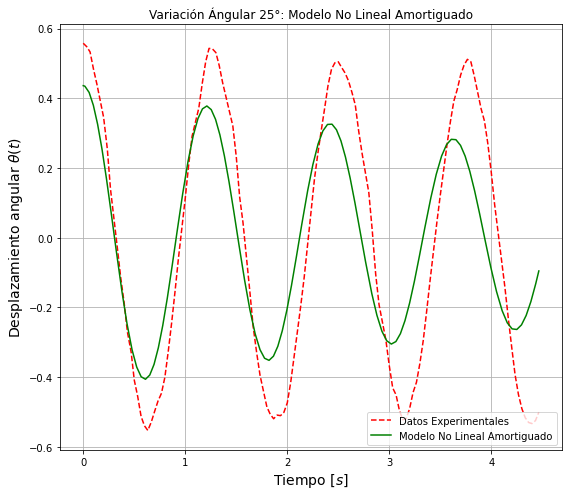

In [31]:
#Grafica 1
fig_c4_1, ax_c4_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c4_1.plot(t4_df, x4_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c4_1.plot(t4_df, c4_lineal, 'k') # Modelo Lineal
ax_c4_1.grid(True)
ax_c4_1.set_title("Variación Ángular 25°: Modelo Lineal")
ax_c4_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c4_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c4_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c4_2, ax_c4_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c4_2.plot(t4_df, x4_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c4_2.plot(c4_no_lineal.t, c4_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c4_2.grid(True)
ax_c4_2.set_title("Variación Ángular 25°: Modelo No Lineal")
ax_c4_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c4_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c4_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c4_3, ax_c4_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c4_3.plot(t4_df, x4_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c4_3.plot(c4_lineal_amort.t, c4_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c4_3.grid(True)
ax_c4_3.set_title("Variación Ángular 25°: Modelo Lineal Amortiguado")
ax_c4_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c4_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c4_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c4_4, ax_c4_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c4_4.plot(t4_df, x4_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c4_4.plot(c4_no_lineal_amort.t, c4_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c4_4.grid(True)
ax_c4_4.set_title("Variación Ángular 25°: Modelo No Lineal Amortiguado")
ax_c4_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c4_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c4_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()


In [72]:
X_c4_1 = np.vstack([c4_lineal, x4_df])
X_c4_2 = np.vstack([np.expand_dims(c4_no_lineal.y[1], axis=1), x4_df])
X_c4_3 = np.vstack([np.expand_dims(c4_lineal_amort.y[1], axis=1), x4_df])
X_c4_4 = np.vstack([np.expand_dims(c4_no_lineal_amort.y[1], axis=1), x4_df])
d1 = pdist(X_c4_1, 'euclidean')
d2 = pdist(X_c4_2, 'euclidean')
d3 = pdist(X_c4_3, 'euclidean')
d4 = pdist(X_c4_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 13422.737817734811
Distancia Euclidiana Modelo No Lineal: 10521.699017424458
Distancia Euclidiana Modelo Lineal Amortiguado: 9725.286109284847
Distancia Euclidiana Modelo No Lineal Amortiguado: 9725.286109284847


## Caso 2: Variación Longitudinal

### Longitud 23.9 cm

In [32]:
ciclos = 10
case = 4
l = 0.239
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.04602421]
Zeta: [0.00732071]
Omega_n: [5.92769215]
Omega_d: [5.92753331]
c crítico: [0.36751691]
c: [0.00269049]


In [33]:
#Valores nominales
g = 9.81
l = 0.239
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x5_df, t5_df, initial_conditions = read_data(case, limit, l)
n = len(t5_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [34]:
c5_no_lineal = solve_ivp(f_nolineal, (0, t5_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c5_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t5_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c5_lineal = f_lineal(initial_conditions[1], t5_df, np.sqrt(A))
c5_lineal_amort = solve_ivp(f_lineal_amort, (0, t5_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

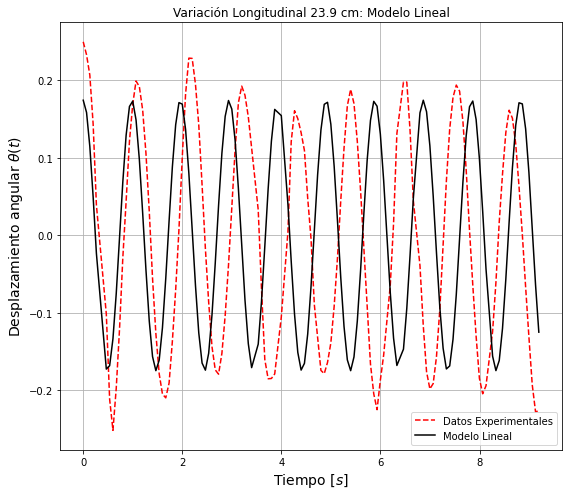

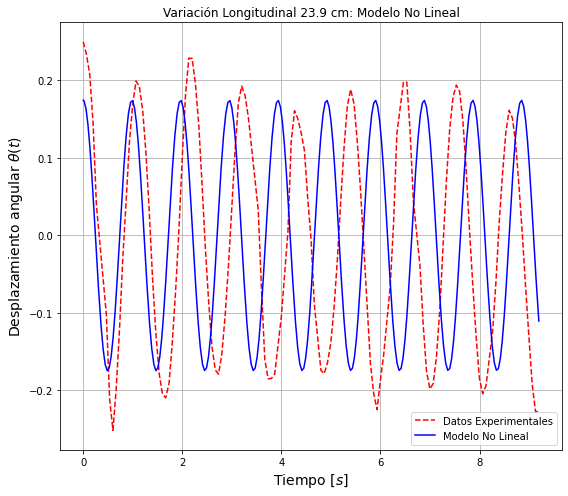

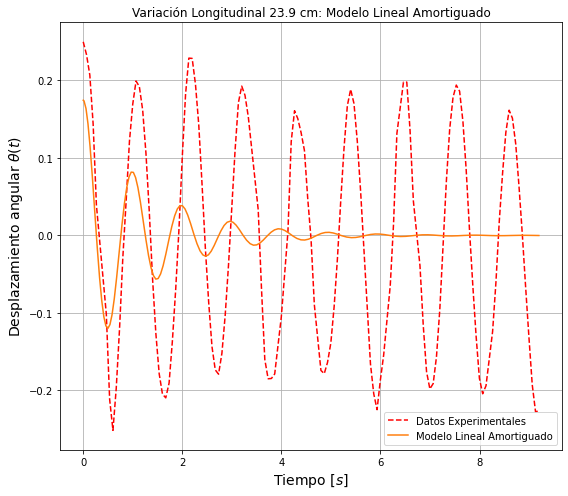

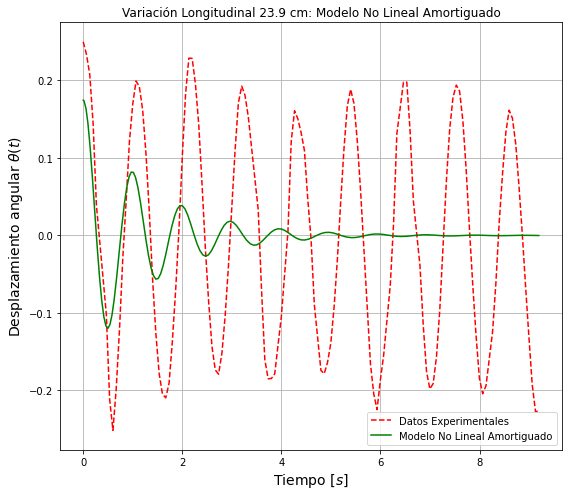

In [35]:
#Grafica 1
fig_c5_1, ax_c5_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c5_1.plot(t5_df, x5_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c5_1.plot(t5_df, c5_lineal, 'k') # Modelo Lineal
ax_c5_1.grid(True)
ax_c5_1.set_title("Variación Longitudinal 23.9 cm: Modelo Lineal")
ax_c5_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c5_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c5_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c5_2, ax_c5_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c5_2.plot(t5_df, x5_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c5_2.plot(c5_no_lineal.t, c5_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c5_2.grid(True)
ax_c5_2.set_title("Variación Longitudinal 23.9 cm: Modelo No Lineal")
ax_c5_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c5_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c5_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c5_3, ax_c5_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c5_3.plot(t5_df, x5_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c5_3.plot(c5_lineal_amort.t, c5_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c5_3.grid(True)
ax_c5_3.set_title("Variación Longitudinal 23.9 cm: Modelo Lineal Amortiguado")
ax_c5_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c5_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c5_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c5_4, ax_c5_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c5_4.plot(t5_df, x5_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c5_4.plot(c5_no_lineal_amort.t, c5_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c5_4.grid(True)
ax_c5_4.set_title("Variación Longitudinal 23.9 cm: Modelo No Lineal Amortiguado")
ax_c5_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c5_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c5_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()


In [73]:
X_c5_1 = np.vstack([c5_lineal, x1_df])
X_c5_2 = np.vstack([np.expand_dims(c5_no_lineal.y[1], axis=1), x5_df])
X_c5_3 = np.vstack([np.expand_dims(c5_lineal_amort.y[1], axis=1), x5_df])
X_c5_4 = np.vstack([np.expand_dims(c5_no_lineal_amort.y[1], axis=1), x5_df])
d1 = pdist(X_c5_1, 'euclidean')
d2 = pdist(X_c5_2, 'euclidean')
d3 = pdist(X_c5_3, 'euclidean')
d4 = pdist(X_c5_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 5309.235996522573
Distancia Euclidiana Modelo No Lineal: 9228.384530933368
Distancia Euclidiana Modelo Lineal Amortiguado: 3877.293510549325
Distancia Euclidiana Modelo No Lineal Amortiguado: 3877.293510549325


### Longitud 36.3 cm

In [36]:
ciclos = 10
case = 5
l = 0.363
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.00772494]
Zeta: [0.00122934]
Omega_n: [5.19271905]
Omega_d: [5.19271513]
c crítico: [0.32194858]
c: [0.00039579]


In [37]:
#Valores nominales
g = 9.81
l = 0.363
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x6_df, t6_df, initial_conditions = read_data(case, limit, l)
n = len(t6_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [38]:
c6_no_lineal = solve_ivp(f_nolineal, (0, t6_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c6_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t6_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c6_lineal = f_lineal(initial_conditions[1], t6_df, np.sqrt(A))
c6_lineal_amort = solve_ivp(f_lineal_amort, (0, t6_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

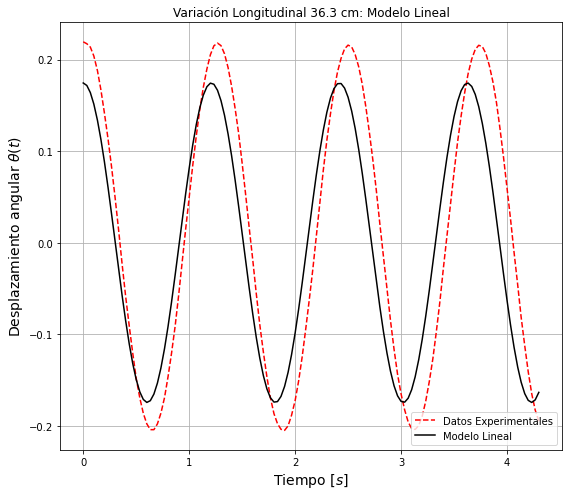

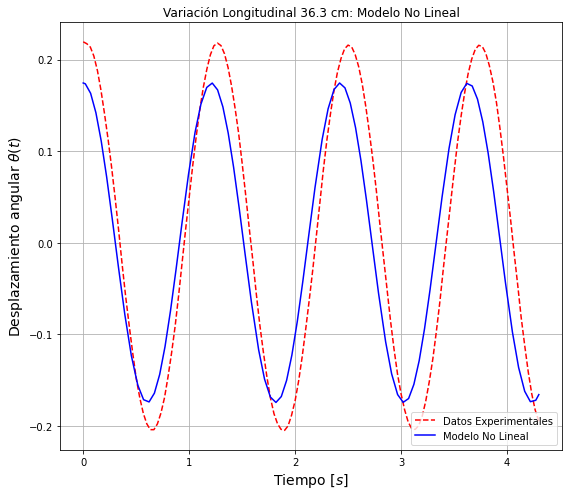

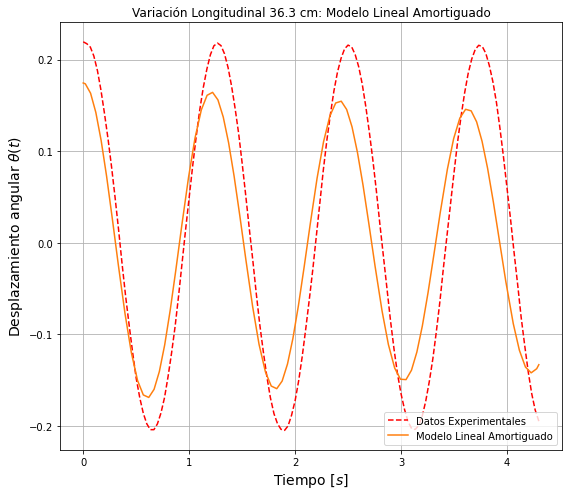

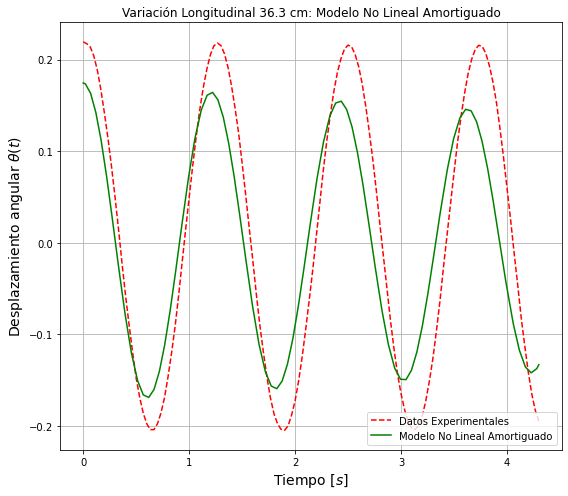

In [40]:
#Grafica 1
fig_c6_1, ax_c6_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c6_1.plot(t6_df, x6_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c6_1.plot(t6_df, c6_lineal, 'k') # Modelo Lineal
ax_c6_1.grid(True)
ax_c6_1.set_title("Variación Longitudinal 36.3 cm: Modelo Lineal")
ax_c6_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c6_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c6_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c6_2, ax_c6_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c6_2.plot(t6_df, x6_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c6_2.plot(c6_no_lineal.t, c6_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c6_2.grid(True)
ax_c6_2.set_title("Variación Longitudinal 36.3 cm: Modelo No Lineal")
ax_c6_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c6_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c6_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c6_3, ax_c6_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c6_3.plot(t6_df, x6_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c6_3.plot(c6_lineal_amort.t, c6_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c6_3.grid(True)
ax_c6_3.set_title("Variación Longitudinal 36.3 cm: Modelo Lineal Amortiguado")
ax_c6_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c6_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c6_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c6_4, ax_c6_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c6_4.plot(t6_df, x6_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c6_4.plot(c6_no_lineal_amort.t, c6_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c6_4.grid(True)
ax_c6_4.set_title("Variación Longitudinal 36.3 cm: Modelo No Lineal Amortiguado")
ax_c6_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c6_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c6_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()


In [74]:
X_c6_1 = np.vstack([c6_lineal, x6_df])
X_c6_2 = np.vstack([np.expand_dims(c6_no_lineal.y[1], axis=1), x6_df])
X_c6_3 = np.vstack([np.expand_dims(c6_lineal_amort.y[1], axis=1), x6_df])
X_c6_4 = np.vstack([np.expand_dims(c6_no_lineal_amort.y[1], axis=1), x6_df])
d1 = pdist(X_c6_1, 'euclidean')
d2 = pdist(X_c6_2, 'euclidean')
d3 = pdist(X_c6_3, 'euclidean')
d4 = pdist(X_c6_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 5348.754803550323
Distancia Euclidiana Modelo No Lineal: 3614.23313703612
Distancia Euclidiana Modelo Lineal Amortiguado: 3489.5564407701618
Distancia Euclidiana Modelo No Lineal Amortiguado: 3489.5564407701618


### Longitud 52.2 cm

In [ ]:
ciclos = 10
case = 6
l = 0.522
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

In [41]:
#Valores nominales
g = 9.81
l = 0.522
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x7_df, t7_df, initial_conditions = read_data(case, limit, l)
n = len(t7_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [42]:
c7_no_lineal = solve_ivp(f_nolineal, (0, t7_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c7_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t7_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c7_lineal = f_lineal(initial_conditions[1], t7_df, np.sqrt(A))
c7_lineal_amort = solve_ivp(f_lineal_amort, (0, t7_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

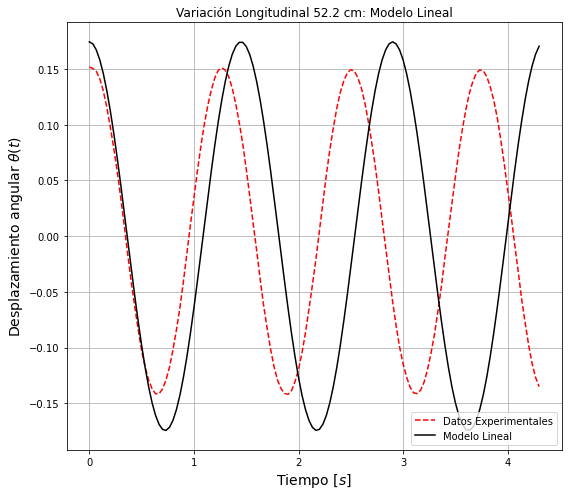

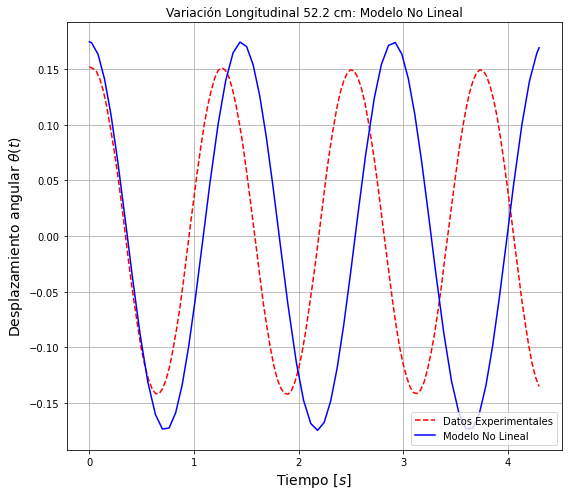

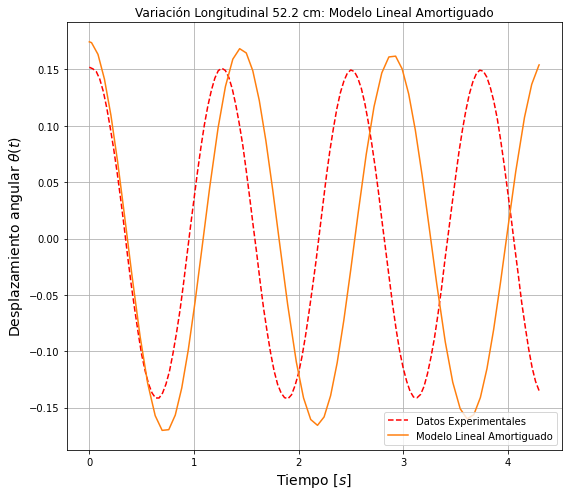

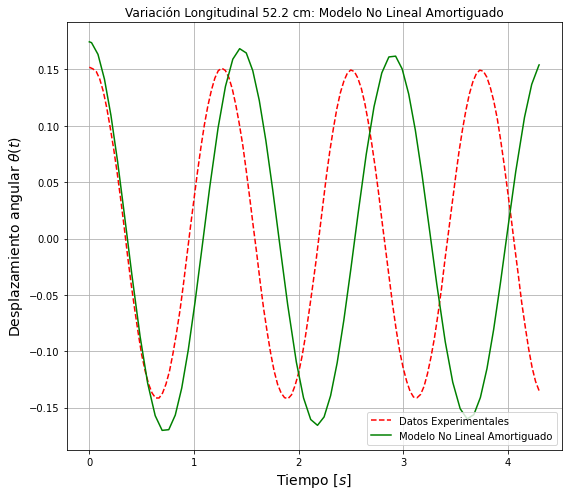

In [43]:
#Grafica 1
fig_c7_1, ax_c7_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c7_1.plot(t7_df, x7_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c7_1.plot(t7_df, c7_lineal, 'k') # Modelo Lineal
ax_c7_1.grid(True)
ax_c7_1.set_title("Variación Longitudinal 52.2 cm: Modelo Lineal")
ax_c7_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c7_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c7_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c7_2, ax_c7_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c7_2.plot(t7_df, x7_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c7_2.plot(c7_no_lineal.t, c7_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c7_2.grid(True)
ax_c7_2.set_title("Variación Longitudinal 52.2 cm: Modelo No Lineal")
ax_c7_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c7_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c7_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c7_3, ax_c7_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c7_3.plot(t7_df, x7_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c7_3.plot(c7_lineal_amort.t, c7_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c7_3.grid(True)
ax_c7_3.set_title("Variación Longitudinal 52.2 cm: Modelo Lineal Amortiguado")
ax_c7_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c7_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c7_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c7_4, ax_c7_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c7_4.plot(t7_df, x7_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c7_4.plot(c7_no_lineal_amort.t, c7_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c7_4.grid(True)
ax_c7_4.set_title("Variación Longitudinal 52.2 cm: Modelo No Lineal Amortiguado")
ax_c7_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c7_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c7_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()


In [75]:
X_c7_1 = np.vstack([c7_lineal, x7_df])
X_c7_2 = np.vstack([np.expand_dims(c7_no_lineal.y[1], axis=1), x7_df])
X_c7_3 = np.vstack([np.expand_dims(c7_lineal_amort.y[1], axis=1), x7_df])
X_c7_4 = np.vstack([np.expand_dims(c7_no_lineal_amort.y[1], axis=1), x7_df])
d1 = pdist(X_c7_1, 'euclidean')
d2 = pdist(X_c7_2, 'euclidean')
d3 = pdist(X_c7_3, 'euclidean')
d4 = pdist(X_c7_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 4422.72902447505
Distancia Euclidiana Modelo No Lineal: 2463.308322732958
Distancia Euclidiana Modelo Lineal Amortiguado: 2415.9513511882024
Distancia Euclidiana Modelo No Lineal Amortiguado: 2415.9513511882024


## Caso 3: Variación Másica

### Masa 0.007 g

In [44]:
ciclos = 10
case = 7
l = 0.359
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.06428581]
Zeta: [0.01022308]
Omega_n: [5.1929865]
Omega_d: [5.19271513]
c crítico: [0.07270181]
c: [0.00074324]


In [45]:
#Valores nominales
g = 9.81
l = 0.359
m = 0.007

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x8_df, t8_df, initial_conditions = read_data(case, limit, l)
n = len(t8_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [46]:
c8_no_lineal = solve_ivp(f_nolineal, (0, t8_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c8_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t8_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c8_lineal = f_lineal(initial_conditions[1], t8_df, np.sqrt(A))
c8_lineal_amort = solve_ivp(f_lineal_amort, (0, t8_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

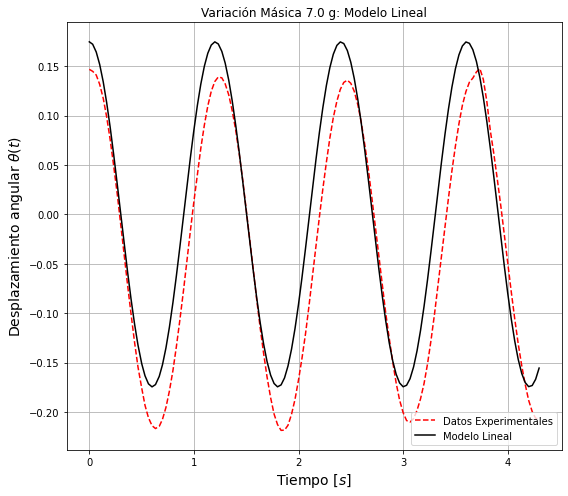

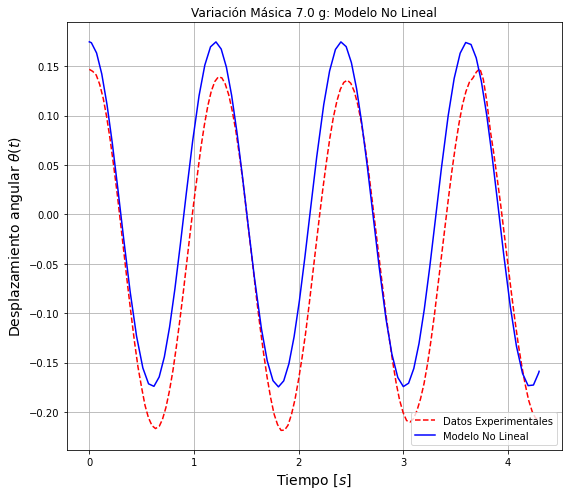

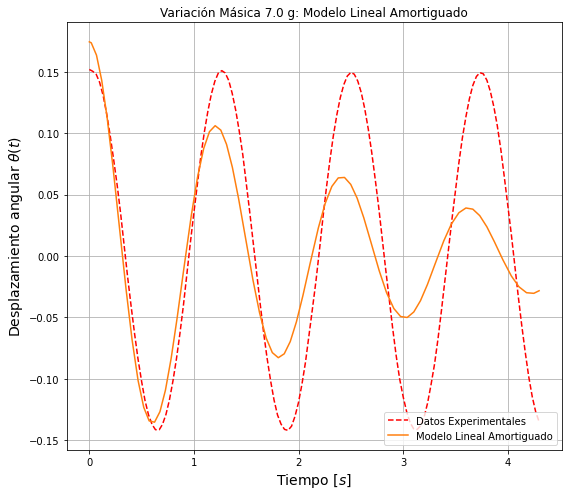

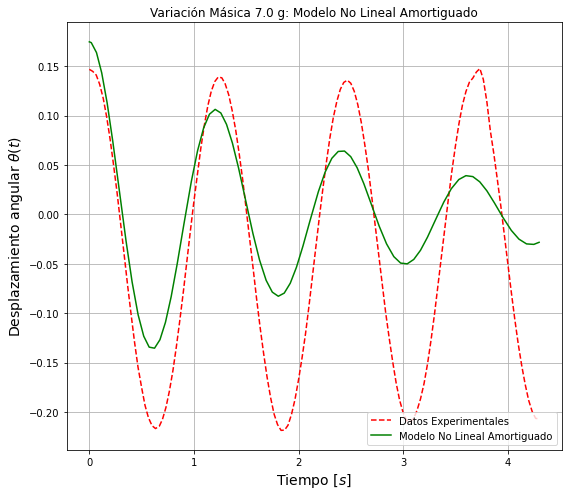

In [47]:
#Grafica 1
fig_c8_1, ax_c8_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c8_1.plot(t8_df, x8_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c8_1.plot(t8_df, c8_lineal, 'k') # Modelo Lineal
ax_c8_1.grid(True)
ax_c8_1.set_title("Variación Másica 7.0 g: Modelo Lineal")
ax_c8_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c8_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c8_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c8_2, ax_c8_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c8_2.plot(t8_df, x8_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c8_2.plot(c8_no_lineal.t, c8_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c8_2.grid(True)
ax_c8_2.set_title("Variación Másica 7.0 g: Modelo No Lineal")
ax_c8_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c8_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c8_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c8_3, ax_c8_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c8_3.plot(t8_df, x7_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c8_3.plot(c8_lineal_amort.t, c8_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c8_3.grid(True)
ax_c8_3.set_title("Variación Másica 7.0 g: Modelo Lineal Amortiguado")
ax_c8_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c8_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c8_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c8_4, ax_c8_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c8_4.plot(t8_df, x8_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c8_4.plot(c8_no_lineal_amort.t, c8_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c8_4.grid(True)
ax_c8_4.set_title("Variación Másica 7.0 g: Modelo No Lineal Amortiguado")
ax_c8_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c8_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c8_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()

In [76]:
X_c8_1 = np.vstack([c8_lineal, x8_df])
X_c8_2 = np.vstack([np.expand_dims(c8_no_lineal.y[1], axis=1), x8_df])
X_c8_3 = np.vstack([np.expand_dims(c8_lineal_amort.y[1], axis=1), x8_df])
X_c8_4 = np.vstack([np.expand_dims(c8_no_lineal_amort.y[1], axis=1), x8_df])
d1 = pdist(X_c8_1, 'euclidean')
d2 = pdist(X_c8_2, 'euclidean')
d3 = pdist(X_c8_3, 'euclidean')
d4 = pdist(X_c8_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 4918.035720314899
Distancia Euclidiana Modelo No Lineal: 3299.0295158978815
Distancia Euclidiana Modelo Lineal Amortiguado: 2580.419859971794
Distancia Euclidiana Modelo No Lineal Amortiguado: 2580.419859971794


### Masa 0.031 g

In [48]:
ciclos = 20
case = 8
l = 0.359
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 20
Delta: [0.00518415]
Zeta: [0.00082503]
Omega_n: [5.15015364]
Omega_d: [5.15015189]
c crítico: [0.31930953]
c: [0.00026344]


In [49]:
#Valores nominales
g = 9.81
l = 0.359
m = 0.031

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x9_df, t9_df, initial_conditions = read_data(case, limit, l)
n = len(t9_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [50]:
c9_no_lineal = solve_ivp(f_nolineal, (0, t9_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c9_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t9_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c9_lineal = f_lineal(initial_conditions[1], t9_df, np.sqrt(A))
c9_lineal_amort = solve_ivp(f_lineal_amort, (0, t9_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

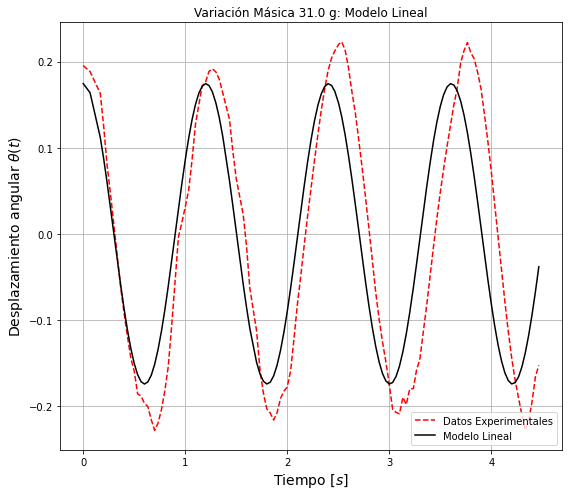

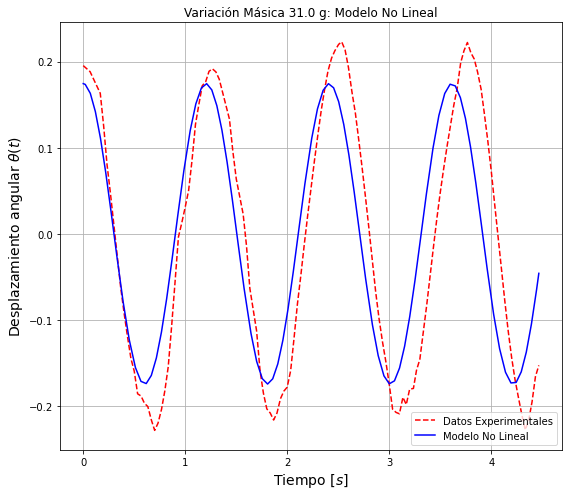

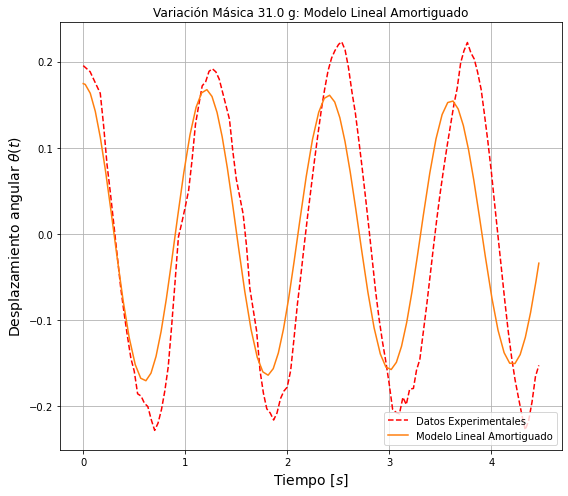

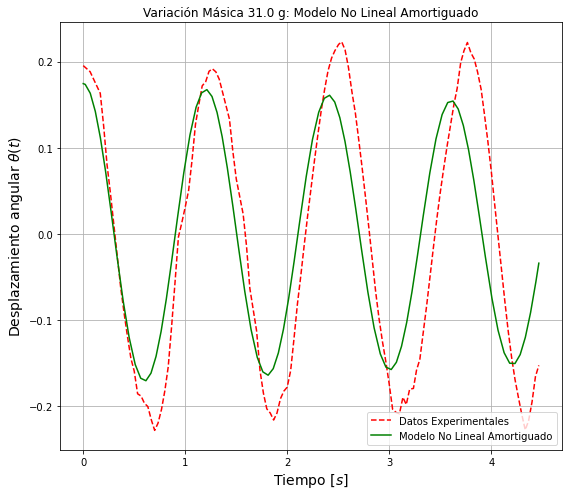

In [51]:
#Grafica 1
fig_c9_1, ax_c9_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c9_1.plot(t9_df, x9_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c9_1.plot(t9_df, c9_lineal, 'k') # Modelo Lineal
ax_c9_1.grid(True)
ax_c9_1.set_title("Variación Másica 31.0 g: Modelo Lineal")
ax_c9_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c9_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c9_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c9_2, ax_c9_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c9_2.plot(t9_df, x9_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c9_2.plot(c9_no_lineal.t, c9_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c9_2.grid(True)
ax_c9_2.set_title("Variación Másica 31.0 g: Modelo No Lineal")
ax_c9_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c9_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c9_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c9_3, ax_c9_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c9_3.plot(t9_df, x9_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c9_3.plot(c9_lineal_amort.t, c9_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c9_3.grid(True)
ax_c9_3.set_title("Variación Másica 31.0 g: Modelo Lineal Amortiguado")
ax_c9_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c9_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c9_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c9_4, ax_c9_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c9_4.plot(t9_df, x9_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c9_4.plot(c9_no_lineal_amort.t, c9_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c9_4.grid(True)
ax_c9_4.set_title("Variación Másica 31.0 g: Modelo No Lineal Amortiguado")
ax_c9_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c9_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c9_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()

In [77]:
X_c9_1 = np.vstack([c9_lineal, x9_df])
X_c9_2 = np.vstack([np.expand_dims(c9_no_lineal.y[1], axis=1), x9_df])
X_c9_3 = np.vstack([np.expand_dims(c9_lineal_amort.y[1], axis=1), x9_df])
X_c9_4 = np.vstack([np.expand_dims(c9_no_lineal_amort.y[1], axis=1), x9_df])
d1 = pdist(X_c9_1, 'euclidean')
d2 = pdist(X_c9_2, 'euclidean')
d3 = pdist(X_c9_3, 'euclidean')
d4 = pdist(X_c9_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 5318.564499525895
Distancia Euclidiana Modelo No Lineal: 3735.732487026798
Distancia Euclidiana Modelo Lineal Amortiguado: 3632.749765795993
Distancia Euclidiana Modelo No Lineal Amortiguado: 3632.749765795993


### Masa 0.050 g

In [52]:
ciclos = 10
case = 9
l = 0.359
_, _, d, z, wn, wd, crit, c = factor_c(case, l, ciclos)

print(f'ciclos: {ciclos}')
print(f'Delta: {d}')
print(f'Zeta: {z}')
print(f'Omega_n: {wn}')
print(f'Omega_d: {wd}')
print(f'c crítico: {crit}')
print(f'c: {c}')

ciclos: 10
Delta: [0.01409735]
Zeta: [0.00224326]
Omega_n: [5.02656089]
Omega_d: [5.02654825]
c crítico: [0.50265609]
c: [0.00112759]


In [53]:
#Valores nominales
g = 9.81
l = 0.359
m = 0.050

#Coeficientes de la ecuación diferencial
A = g / l

B_ = c / (m * l**2)
B = B_[0]

limit = 130
_, x10_df, t10_df, initial_conditions = read_data(case, limit, l)
n = len(t10_df)
#plt.plot(t1_df, x1_df)
#plt.show()

### Resolviendo las ecuaciones diferenciales de manera numérica

In [54]:
c10_no_lineal = solve_ivp(f_nolineal, (0, t10_df[n-1]), initial_conditions, args=[A], method='RK45', rtol=1e-8)
c10_no_lineal_amort = solve_ivp(f_lineal_amort, (0, t10_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)
c10_lineal = f_lineal(initial_conditions[1], t10_df, np.sqrt(A))
c10_lineal_amort = solve_ivp(f_lineal_amort, (0, t10_df[n-1]), initial_conditions, args=[A, B], method='RK45', rtol=1e-8)

### Graficando

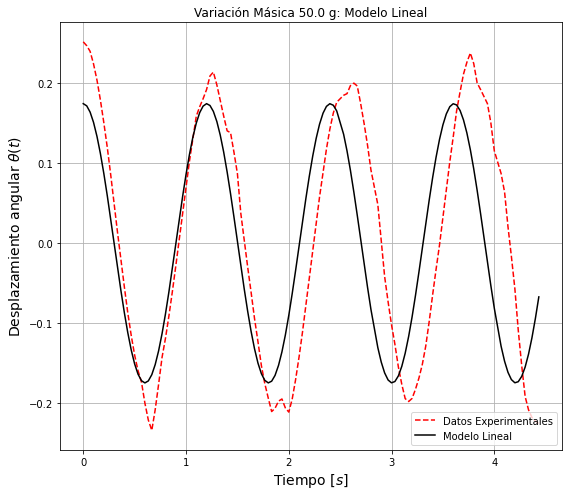

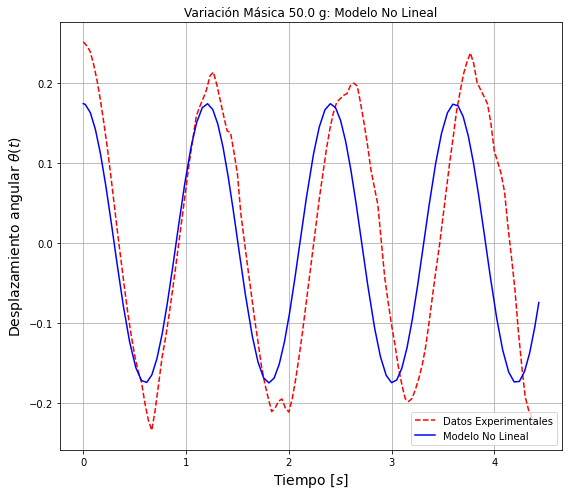

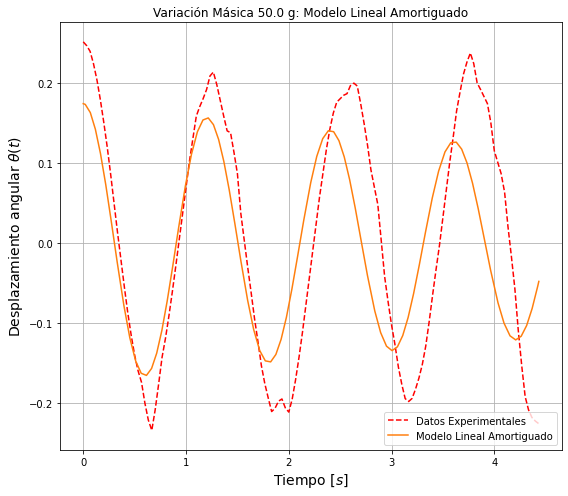

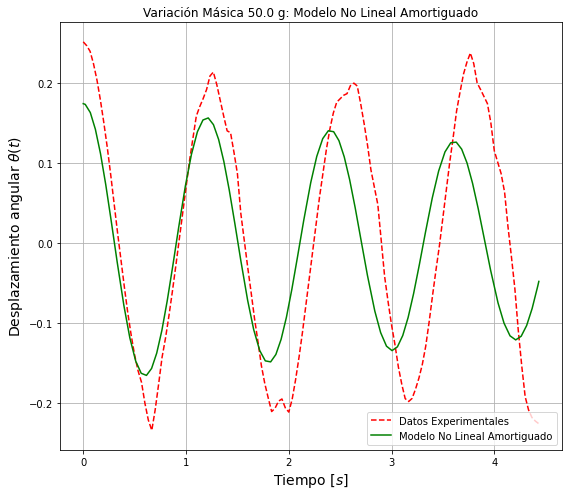

In [55]:
#Grafica 1
fig_c10_1, ax_c10_1 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c10_1.plot(t10_df, x10_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c10_1.plot(t10_df, c10_lineal, 'k') # Modelo Lineal
ax_c10_1.grid(True)
ax_c10_1.set_title("Variación Másica 50.0 g: Modelo Lineal")
ax_c10_1.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c10_1.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c10_1.legend(['Datos Experimentales', 'Modelo Lineal'], loc='lower right')
plt.show()

#Grafica 2
fig_c10_2, ax_c10_2 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c10_2.plot(t10_df, x10_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c10_2.plot(c10_no_lineal.t, c10_no_lineal.y[1], 'b') # Modelo No Lineal
ax_c10_2.grid(True)
ax_c10_2.set_title("Variación Másica 50.0 g: Modelo No Lineal")
ax_c10_2.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c10_2.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c10_2.legend(['Datos Experimentales', 'Modelo No Lineal'], loc='lower right')
plt.show()

#Grafica 3
fig_c10_3, ax_c10_3 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c10_3.plot(t10_df, x10_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c10_3.plot(c10_lineal_amort.t, c10_lineal_amort.y[1], 'tab:orange') # Modelo Lineal Amortiguado
ax_c10_3.grid(True)
ax_c10_3.set_title("Variación Másica 50.0 g: Modelo Lineal Amortiguado")
ax_c10_3.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c10_3.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c10_3.legend(['Datos Experimentales', 'Modelo Lineal Amortiguado'], loc='lower right')
plt.show()

#Grafica 4
fig_c10_4, ax_c10_4 = plt.subplots(figsize=(8, 7), tight_layout=True)
ax_c10_4.plot(t10_df, x10_df, '-r', linestyle='dashed') # Datos Experimentales
ax_c10_4.plot(c10_no_lineal_amort.t, c10_no_lineal_amort.y[1], 'g') # Modelo No Lineal Amortiguado
ax_c10_4.grid(True)
ax_c10_4.set_title("Variación Másica 50.0 g: Modelo No Lineal Amortiguado")
ax_c10_4.set_ylabel(r"Desplazamiento angular $\theta(t)$", fontsize=14)
ax_c10_4.set_xlabel(r"Tiempo $[s]$", fontsize=14)
ax_c10_4.legend(['Datos Experimentales', 'Modelo No Lineal Amortiguado'], loc='lower right')
plt.show()

In [78]:
X_c10_1 = np.vstack([c10_lineal, x10_df])
X_c10_2 = np.vstack([np.expand_dims(c10_no_lineal.y[1], axis=1), x10_df])
X_c10_3 = np.vstack([np.expand_dims(c10_lineal_amort.y[1], axis=1), x10_df])
X_c10_4 = np.vstack([np.expand_dims(c10_no_lineal_amort.y[1], axis=1), x10_df])
d1 = pdist(X_c10_1, 'euclidean')
d2 = pdist(X_c10_2, 'euclidean')
d3 = pdist(X_c10_3, 'euclidean')
d4 = pdist(X_c10_4, 'euclidean')
print(f'Distancia Euclidiana Modelo Lineal: {d1.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal: {d2.sum()}')
print(f'Distancia Euclidiana Modelo Lineal Amortiguado: {d3.sum()}')
print(f'Distancia Euclidiana Modelo No Lineal Amortiguado: {d4.sum()}')

Distancia Euclidiana Modelo Lineal: 5405.6907065231135
Distancia Euclidiana Modelo No Lineal: 3753.626737720397
Distancia Euclidiana Modelo Lineal Amortiguado: 3528.187372579656
Distancia Euclidiana Modelo No Lineal Amortiguado: 3528.187372579656
